## Installation

To run this you need several packages. First of all, you need anaconda, which you most likely already have if you're viewing this through jupyter. If not then check the readme on the class page.

System requirements: This should work on all operating systems (Linux, Mac, and Windows). However, several of the environments in the OpenAI-gym require additional simulators which don't aren't easy to get on Windows. In any case, it is strongly recommended that you use Linux, although you should be ok with Mac. (HINT: if you're on Windows check out the Windows Subsystem for Linux (WSL), although it'll make visualizing your policies a little tricky).

Then install the following packages (using conda or pip):

- pytorch --> `conda install pytorch -c pytorch`
- gym --> `pip install gym`
- gym (the cool environments, doesnt work on Windows) --> `pip install gym[all]`
(When install gym[all] don't worry if the mujoco installation doesn't work. That's a more advanced 3D physics simulator that has to be set up separately (see website). Anyway, we don't need it necessarily).

In [356]:
# If you're using colab, this will install the necessary packages!
!pip install torch
!pip install gym
!wget https://pjreddie.com/media/files/rlhw_util.py

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
--2018-11-30 19:23:13--  https://pjreddie.com/media/files/rlhw_util.py
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4071 (4.0K) [application/octet-stream]
Saving to: ‘rlhw_util.py.1’

rlhw_util.py.1      100%[===================>]   3.98K  --.-KB/s    in 0s      

2018-11-30 19:23:14 (597 MB/s) - ‘rlhw_util.py.1’ saved [4071/4071]



In [357]:
import sys, os, time
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch import distributions
from torch.distributions import Categorical
from itertools import islice

import gym

# Introduction
Welcome to the RL playground. Your task is to implement the REINFORCE and A3C algorithm to solve various OpenAI-gym environments. If you are not familiar with OpenAI-gym, stop reading and visit https://gym.openai.com/envs/ to see all the tasks you can try to solve.

In this homework, we will only look at tasks with a discrete (and small) action space. That being said, both algorithms can be modified slightly to work on tasks with continuous action spaces. For full credit you must fill in the code below so you achieve an average total reward per episode on the cartpole task (CartPole-v1) of at least 499 (for an episode length of 500) for both REINFORCE and A3C. Then you must apply your code to any one other environment in OpenAI-gym, and plot and compare the learning curves (average total reward per episode vs number of episodes trained on) between REINFORCE and A3C (where at least one of the algorithms shows significant improvement from initialization).

Below there's an overview of what every iteration will look like, regardless of whether you want to train or evaluate your agent.

In [358]:
from rlhw_util import * # <-- look whats inside here - it could save you a lot of work!

def run_iteration(mode, N, agent, gen, horizon=None, render=False):
    train = mode == 'train'
    if train:
        agent.train()
    else:
        agent.eval()

    states, actions, rewards = zip(*[gen(horizon=horizon, render=render) for _ in range(N)])

    loss = None
    if train:
        loss = agent.learn(states, actions, rewards)

    reward = sum([r.sum() for r in rewards]) / N

    return reward, loss

## The Actor

We need to learn a policy which, given some state, outputs a distribution over all possible actions. As this is deep RL, we'll use a deep neural network to turn the observed state into the requisite action distribution. From this action distribution we can choose what action to take using `get_action`. Pytorch, brilliant as it is, makes our task incredibly easy, as we can use the `torch.distributions.Categorical` class for sampling.

You can experiment with all sorts of network architectures, but remember this is RL, not image classification on ImageNet, so you probably won't need a very deep network (HINT: look below at the state and action dimensionality to get a feel for the task).

In [359]:
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        
        # TODO: Fill in the code to define you policy
        # raise NotImplementedError
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)
              
    def forward(self, state):
        
        # TODO: Fill in the code to run a forward pass of your policy to get a distribution over actions (HINT: probabilities sum to 1)
        # raise NotImplementedError
        state = F.tanh(self.fc1(state))
        state = F.tanh(self.fc2(state))
        state = F.softmax(self.fc3(state), dim=-1)
        return state
      
    def get_policy(self, state):
        return Categorical(self(state))

    def get_action(self, state, greedy=None):
        if greedy is None:
            greedy = not self.training

        policy = self.get_policy(state)
        return MLE(policy) if greedy else policy.sample()

## The REINFORCE Agent

The Actor defines our policy, but we also have to define how and when we'll be updating our policy, which brings us to the agent. The agent will house the policy (an `Actor`), and can then be used to generate rollouts (using `forward()`) or update the policy given a list of rollouts (using `learn()`).

The REINFORCE algorithm naively uses the returns directly to weight the gradients, however this makes the variance in the policy gradient estimation very large. As a result, we will use a baseline which is a linear model which takes in a state and outputs the return (sounds like a value function, right?). Except we're not going to train our baseline using gradient descent, instead we'll just solve the linear system analytically in every iteration, and use the solution in the next iteration. Don't worry about training/updating the baseline, but you do have to use it in the right way. (Optional experiment: try removing the baseline and see how performance changes)

In [360]:
class REINFORCE(nn.Module):
    
    def __init__(self, state_dim, action_dim, discount=0.97, lr=1e-3, weight_decay=1e-4):
        super(REINFORCE, self).__init__()
        self.actor = Actor(state_dim, action_dim)
        
        self.baseline = nn.Linear(state_dim, 1)
        
        # TODO: create an optimizer for the parameters of your actor (HINT: use the passed in lr and weight_decay args)
        # raise NotImplementedError
        self.optimizer = optim.Adam(self.actor.parameters(), lr=lr, weight_decay=weight_decay)
        self.discount = discount
        
    def forward(self, state):
        return self.actor.get_action(state)
    
    def learn(self, states, actions, rewards):
        '''
        Takes in three arguments each of which is a list with equal length. Each element in the list is a 
        pytorch tensor with 1 row for every step in the episode, and the columns are state_dim, action_dim, 
        and 1, respectively.
        '''
        
        # TODO: implement the REINFORCE algorithm (HINT: check the slides/papers)
        # raise NotImplementedError
        returns = [compute_returns(rs, discount=self.discount) for rs in rewards]
        
        states, actions, returns = torch.cat(states), torch.cat(actions), torch.cat(returns)
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        loss = []
        for s, a, r in zip(states, actions, returns):
            sample = self.actor.get_policy(s)
            log_prob = sample.log_prob(a)
            loss.append(-log_prob * r)
        
        self.optimizer.zero_grad()
        loss = torch.stack(loss).sum()
        loss.backward()
        self.optimizer.step()
                
        error = F.mse_loss(self.baseline(states).squeeze(), returns).detach()
        solve(states, returns, out=self.baseline)
        #error = F.mse_loss(self.baseline(states).squeeze(), returns).detach()
        
        return error.item() # Returns a rough estimate of the error in the baseline (dont worry about this too much)

## The Critic

Now we can introduce a critic, which is essentially a value function to estimate the expected discounted reward of a state.

In [361]:
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        
        # TODO: define your value function network
        # raise NotImplementedError
        
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)
        

    def forward(self, state):
        
        # TODO: apply your value function network to get a value given this batch of states
        # raise NotImplementedError
        state = F.tanh(self.fc1(state))
        state = F.tanh(self.fc2(state))
        state = F.softmax(self.fc3(state), dim=-1)
        return state        

## The A3C Agent

Now we can put the actor and critic together using the A3C algorithm. It turns out, the tasks in the gym are all so simple that there is essentially no gain in parallelization, so technically we're implementing A2C (no async), but the RL part is the same.

In [362]:
class A3C(nn.Module):
    
    def __init__(self, state_dim, action_dim, discount=0.97, lr=1e-3, weight_decay=1e-4):
        super(A3C, self).__init__()
        self.actor = Actor(state_dim, action_dim)
        self.critic = Critic(state_dim)
        
        # TODO: create an optimizer for the parameters of your actor (HINT: use the passed in lr and weight_decay args)
        # raise NotImplementedError
        # (HINT: the actor and critic have different objectives, so how many optimizers do you need?)

        self.optimizer1 = optim.Adam(self.actor.parameters(), lr=lr, weight_decay=weight_decay)
        self.optimizer2 = optim.Adam(self.critic.parameters(), lr=lr, weight_decay=weight_decay)
        self.discount = discount
        
        
    def forward(self, state):
        return self.actor.get_action(state)
    
    def learn(self, states, actions, rewards):
        
        returns = [compute_returns(rs, discount=self.discount) for rs in rewards]
        
        states, actions, returns = torch.cat(states), torch.cat(actions), torch.cat(returns)
        
        # TODO: implement A3C (HINT: algorithm details found in A3C paper supplement) 
        # (HINT2: the algorithm is actually very similar to REINFORCE, the only difference is now we have a critic, what might that do?) 
        # raise NotImplementedError
        eps = np.finfo(np.float32).eps.item()
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + eps)
        actor_loss = []
        critic_loss = []
        for s, a, r in zip(states, actions, returns):
            sample = self.actor.get_policy(s)
            log_prob = sample.log_prob(a)
            value = self.critic(s)
            ra = r - value.item()
            actor_loss.append(-log_prob * ra)
            critic_loss.append(F.smooth_l1_loss(value, torch.tensor([r])))

        self.optimizer1.zero_grad()
        self.optimizer2.zero_grad()
        
        actor_loss = torch.stack(actor_loss).sum()
        critic_loss = torch.stack(critic_loss).sum()
        
        actor_loss.backward()
        critic_loss.backward()

        self.optimizer1.step()
        self.optimizer2.step()

        error = F.mse_loss(self.critic(states).squeeze(), returns).detach()
        return error.item()

## Part 1: Balancing a pole with a cart

First, we'll test both algorithms on a very simple toy system: the cartpole. Eventhough it's very low dimensional (state=4, action=2), this task is nontrival because it is underactuated. Nevertheless after a few thousand episodes our policy shouldn't have a problem! 

In [363]:
# Optimization hyperparameters
lr = 1e-3
weight_decay = 1e-4

In [346]:
!pip install box2d-py
!pip install gym[Box_2D]
import gym

distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
  gym 0.10.9 does not provide the extra 'box_2d'
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [364]:
# env_name = 'CartPole-v1' 
env_name = 'LunarLander-v2'
e = Pytorch_Gym_Env(env_name)
state_dim = e.observation_space.shape[0]
action_dim = e.action_space.n

In [369]:
# Choose what agent to use
agent = REINFORCE(state_dim, action_dim, lr=lr, weight_decay=weight_decay)
# agent = A3C(state_dim, action_dim, lr=lr, weight_decay=weight_decay)

total_episodes = 0
print(agent) # Let's take a look at what we're working with...

REINFORCE(
  (actor): Actor(
    (fc1): Linear(in_features=8, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=4, bias=True)
  )
  (baseline): Linear(in_features=8, out_features=1, bias=True)
)


In [370]:
gen = Generator(e, agent)

### Let's do this!!

Below is the loop to train and evaluate your agent. You can play around with the number of iterations to run, and the number of rollouts per iteration. 

You can rerun this cell multiple times to keep training your model for more episodes. In any case, it shouldn't take more than 30 min to an 1 hour to train. (training never took me more than 5 min). HINT: Keep an eye on the eval_reward, it'll be pretty noisy, but if that should be slowly increasing.

In [202]:
# REinforce - cartpole
num_iter = 200
num_train = 5
num_eval = 10 # dont change this
log_dict1 = {}
for itr in range(num_iter):
    #agent.model.epsilon = epsilon * epsilon_decay ** (total_episodes / epsilon_decay_episodes)
    #print('** Iteration {}/{} **'.format(itr+1, num_iter))
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    log_dict1[total_episodes] = eval_reward
    if eval_reward > 499 and env_name == 'CartPole-v1': # dont change this
        print('Success!!! You have solved cartpole task! Time for a bigger challenge!')
    
    # save model
print('Done')

/home/lilly/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep:5: reward=13.400, loss=1.374, eval=13.900
Ep:10: reward=22.800, loss=3.225, eval=12.500
Ep:15: reward=26.600, loss=1.019, eval=16.900
Ep:20: reward=23.200, loss=0.968, eval=21.700
Ep:25: reward=22.000, loss=1.686, eval=28.400
Ep:30: reward=20.200, loss=1.579, eval=42.300
Ep:35: reward=44.200, loss=1.264, eval=43.400
Ep:40: reward=36.400, loss=1.134, eval=70.600
Ep:45: reward=31.600, loss=1.079, eval=68.200
Ep:50: reward=39.200, loss=1.256, eval=68.700
Ep:55: reward=28.400, loss=1.138, eval=60.900
Ep:60: reward=39.400, loss=2.111, eval=64.200
Ep:65: reward=70.200, loss=1.063, eval=41.900
Ep:70: reward=62.200, loss=2.622, eval=63.900
Ep:75: reward=46.400, loss=0.626, eval=68.800
Ep:80: reward=53.600, loss=4.509, eval=95.100
Ep:85: reward=48.400, loss=1.063, eval=83.900
Ep:90: reward=66.600, loss=15.012, eval=72.700
Ep:95: reward=48.600, loss=0.468, eval=73.400
Ep:100: reward=72.600, loss=1.350, eval=62.500
Ep:105: reward=71.800, loss=0.938, eval=74.200
Ep:110: reward=60.600, loss=6.90

Ep:660: reward=353.600, loss=1.869, eval=394.800
Ep:665: reward=345.600, loss=1.372, eval=415.800
Ep:670: reward=337.600, loss=1.084, eval=450.400
Ep:675: reward=326.800, loss=0.968, eval=476.200
Ep:680: reward=378.600, loss=1.266, eval=496.300
Ep:685: reward=409.800, loss=1.090, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:690: reward=478.800, loss=1.001, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:695: reward=365.800, loss=0.995, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:700: reward=428.800, loss=1.277, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:705: reward=419.400, loss=0.990, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:710: reward=500.000, loss=0.883, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:715: reward=463.800, loss=1.009,

In [203]:
def plot_fig(x_val, y_val, title, x_label, y_label):
    plt.figure(figsize=(20, 10))
    plt.plot(x_val, y_val)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [204]:
def plot_figs(x_val, y1_val, y2_val, title, x_label, y_label, str1, str2):
    plt.figure(figsize=(20, 10))
    plt.plot(x_val, y1_val, color='red', label=str1)
    plt.plot(x_val, y2_val, color='blue', label=str2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()

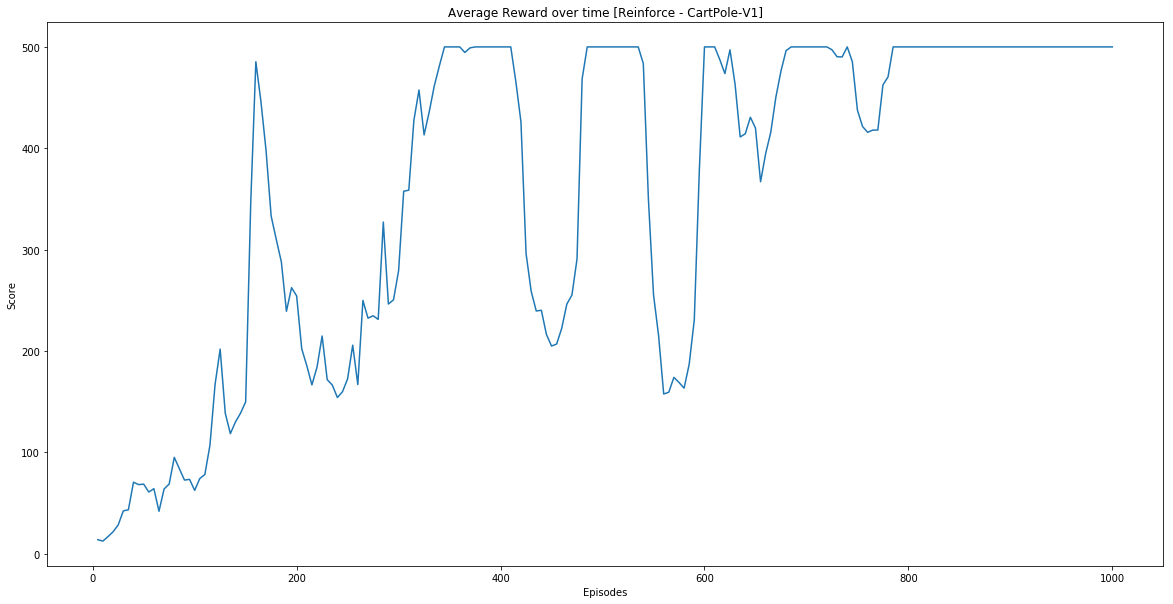

In [205]:
title = "Average Reward over time [Reinforce - CartPole-V1]"
x_label = "Episodes"
y_label = "Score"
plot_fig([int(i) for i in log_dict1.keys()], [float(v) for v in log_dict1.values()], title, x_label, y_label)

In [197]:
# A3C - cartpole
num_iter = 200
num_train = 5
num_eval = 10 # dont change this
log_dict = {}
for itr in range(num_iter):
    #agent.model.epsilon = epsilon * epsilon_decay ** (total_episodes / epsilon_decay_episodes)
    #print('** Iteration {}/{} **'.format(itr+1, num_iter))
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    log_dict[total_episodes] = eval_reward
    if eval_reward > 499 and env_name == 'CartPole-v1': # dont change this
        print('Success!!! You have solved cartpole task! Time for a bigger challenge!')
    
    # save model
print('Done')

/home/lilly/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep:5: reward=16.000, loss=1.987, eval=9.100
Ep:10: reward=23.000, loss=1.991, eval=121.500
Ep:15: reward=28.000, loss=1.993, eval=94.500
Ep:20: reward=54.400, loss=1.996, eval=52.200
Ep:25: reward=30.200, loss=1.993, eval=41.600
Ep:30: reward=32.600, loss=1.994, eval=41.000
Ep:35: reward=38.400, loss=1.995, eval=52.600
Ep:40: reward=36.400, loss=1.995, eval=55.200
Ep:45: reward=20.400, loss=1.990, eval=72.800
Ep:50: reward=33.800, loss=1.994, eval=75.000
Ep:55: reward=41.200, loss=1.995, eval=95.000
Ep:60: reward=28.800, loss=1.993, eval=52.900
Ep:65: reward=39.600, loss=1.995, eval=66.500
Ep:70: reward=52.000, loss=1.996, eval=61.500
Ep:75: reward=54.600, loss=1.996, eval=49.800
Ep:80: reward=39.200, loss=1.995, eval=51.800
Ep:85: reward=38.200, loss=1.995, eval=45.200
Ep:90: reward=34.000, loss=1.994, eval=57.600
Ep:95: reward=30.200, loss=1.993, eval=76.800
Ep:100: reward=35.200, loss=1.994, eval=71.800
Ep:105: reward=32.400, loss=1.994, eval=144.400
Ep:110: reward=89.400, loss=1.99

Ep:685: reward=238.000, loss=1.999, eval=294.600
Ep:690: reward=280.600, loss=1.999, eval=314.200
Ep:695: reward=263.400, loss=1.999, eval=391.600
Ep:700: reward=367.600, loss=1.999, eval=479.300
Ep:705: reward=446.800, loss=2.000, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:710: reward=500.000, loss=2.000, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:715: reward=500.000, loss=2.000, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:720: reward=500.000, loss=2.000, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:725: reward=500.000, loss=2.000, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:730: reward=500.000, loss=2.000, eval=500.000
Success!!! You have solved cartpole task! Time for a bigger challenge!
Ep:735: reward=447.600, loss=2.000, eval=500.000
Success!!! You have solved cartpole

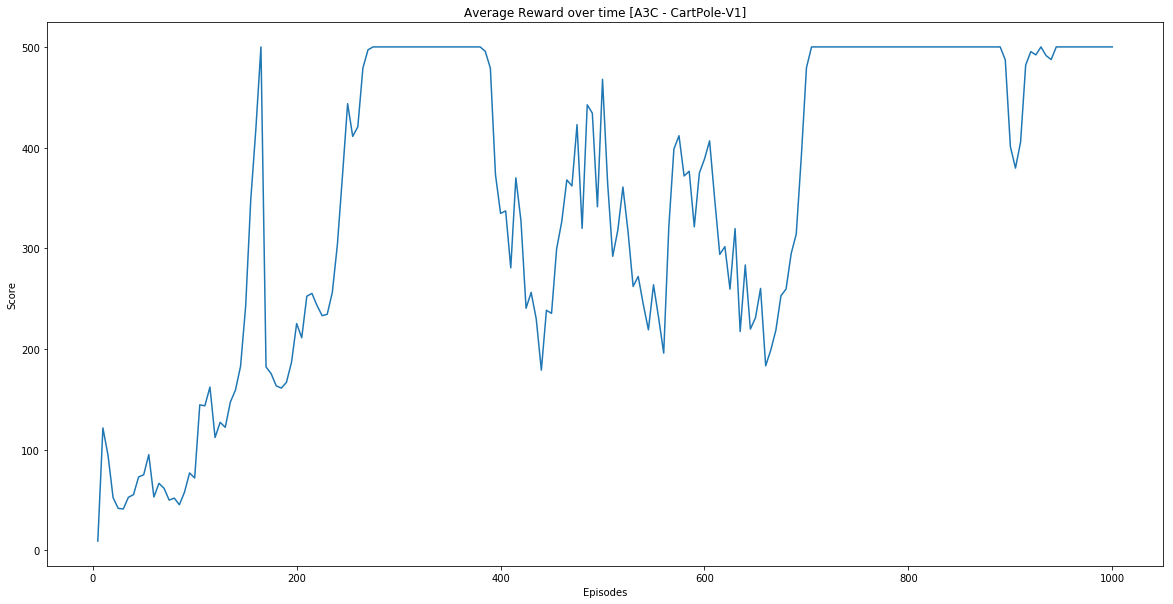

In [198]:
title = "Average Reward over time [A3C - CartPole-V1]"
x_label = "Episodes"
y_label = "Score"
plot_fig([int(i) for i in log_dict.keys()], [float(v) for v in log_dict.values()], title, x_label, y_label)

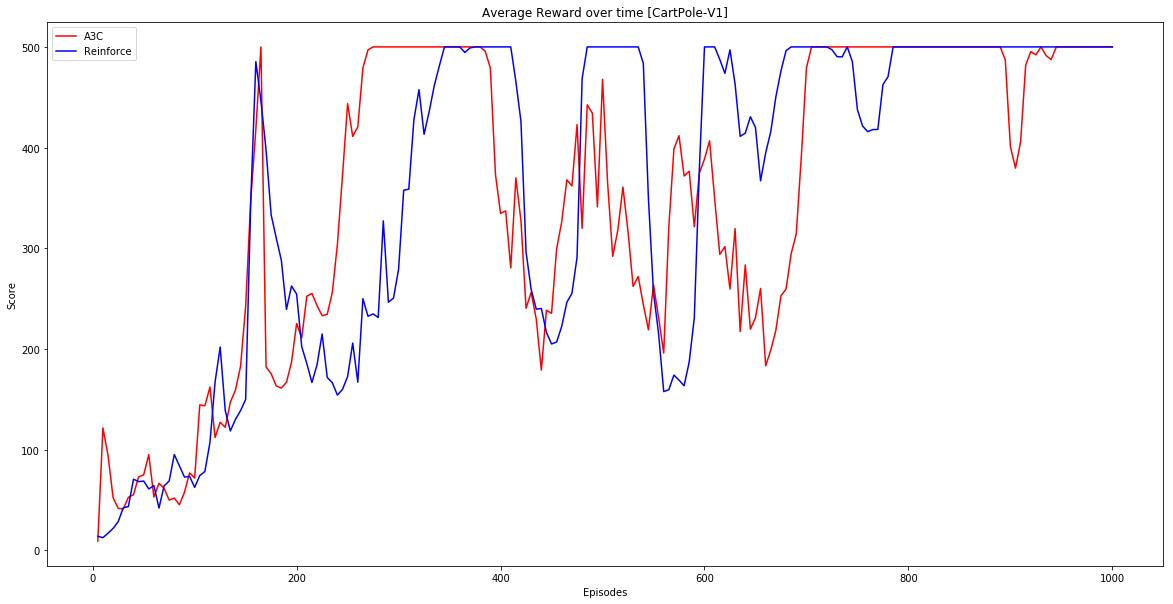

In [286]:
title = "Average Reward over time [CartPole-V1]"
x_label = "Episodes"
y_label = "Score"
plot_figs([int(i) for i in log_dict.keys()], [float(v) for v in log_dict.values()], 
          [float(v) for v in log_dict1.values()], title, x_label, y_label, "A3C", "Reinforce")

In [319]:
# REinforce - lunar lander
num_iter = 257
num_train = 10
num_eval = 10 # dont change this
log_dict4 = {}
for itr in range(num_iter):
    #agent.model.epsilon = epsilon * epsilon_decay ** (total_episodes / epsilon_decay_episodes)
    #print('** Iteration {}/{} **'.format(itr+1, num_iter))
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    log_dict4[total_episodes] = eval_reward
    if eval_reward > 0:
        print ('positive eval reward achieved!........')
    if eval_reward > 50 and env_name == 'LunarLander-v2': # dont change this
        print('Success!!! You have solved LunarLander task! Time for a bigger challenge!')
    
    # save model
print('Done')

/home/lilly/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep:10: reward=-246.399, loss=1.399, eval=-500.645
Ep:20: reward=-153.047, loss=0.833, eval=-289.378
Ep:30: reward=-176.709, loss=1.508, eval=-912.388
Ep:40: reward=-121.319, loss=5.990, eval=-749.123
Ep:50: reward=-109.861, loss=1.763, eval=-592.026
Ep:60: reward=-119.286, loss=0.824, eval=-809.857
Ep:70: reward=-173.708, loss=1.868, eval=-631.186
Ep:80: reward=-180.421, loss=2.008, eval=-883.146
Ep:90: reward=-152.379, loss=1.108, eval=-899.804
Ep:100: reward=-150.635, loss=1.268, eval=-835.599
Ep:110: reward=-164.017, loss=1.289, eval=-1017.144
Ep:120: reward=-109.803, loss=1.042, eval=-740.526
Ep:130: reward=-135.906, loss=1.079, eval=-781.707
Ep:140: reward=-147.142, loss=0.616, eval=-978.019
Ep:150: reward=-136.956, loss=0.835, eval=-884.492
Ep:160: reward=-139.471, loss=0.827, eval=-1337.704
Ep:170: reward=-113.822, loss=1.420, eval=-833.512
Ep:180: reward=-192.066, loss=1.824, eval=-704.512
Ep:190: reward=-176.915, loss=1.298, eval=-1013.123
Ep:200: reward=-195.141, loss=0.823, 

Ep:1570: reward=68.805, loss=0.817, eval=99.830
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1580: reward=121.271, loss=1.018, eval=143.578
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1590: reward=44.071, loss=0.884, eval=118.484
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1600: reward=94.345, loss=0.794, eval=24.279
positive eval reward achieved!........
Ep:1610: reward=147.132, loss=0.879, eval=68.821
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1620: reward=87.763, loss=0.751, eval=1.566
positive eval reward achieved!........
Ep:1630: reward=107.217, loss=0.614, eval=-31.229
Ep:1640: reward=76.455, loss=1.108, eval=-71.591
Ep:1650: reward=67.746, loss=1.273, eval=-58.129
Ep:1660: reward=82.428, loss=0.

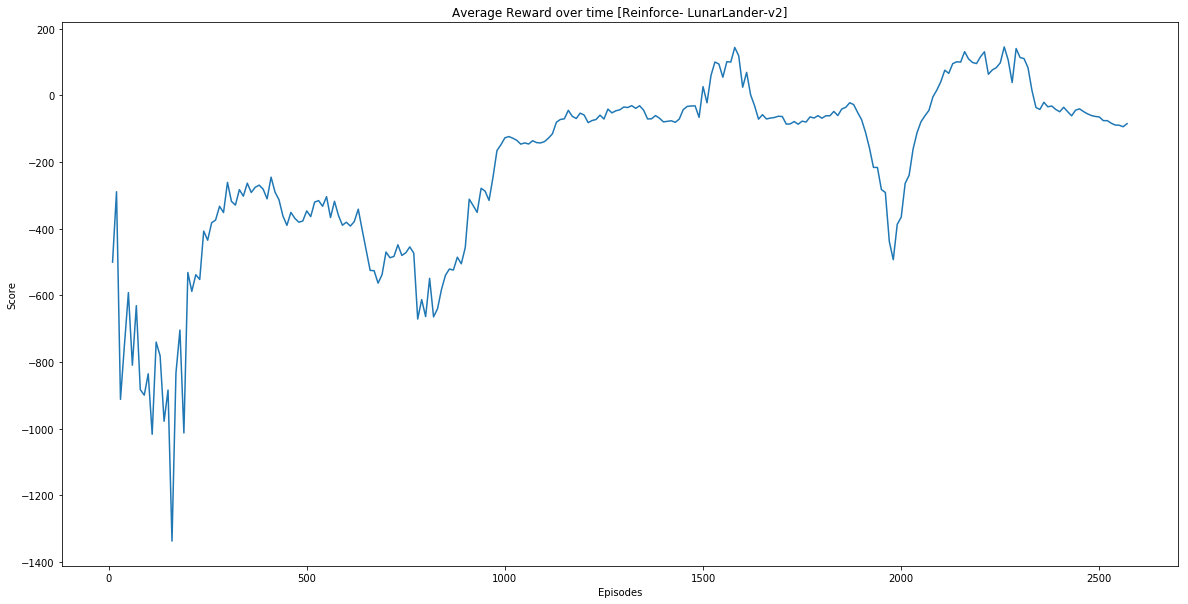

In [320]:
title = "Average Reward over time [Reinforce- LunarLander-v2]"
x_label = "Episodes"
y_label = "Score"
plot_fig([int(i) for i in log_dict4.keys()], [float(v) for v in log_dict4.values()], title, x_label, y_label)

In [307]:
# A3C - lunar lander
num_iter = 400
num_train = 10
num_eval = 10 # dont change this
log_dict3 = {}
for itr in range(num_iter):
    #agent.model.epsilon = epsilon * epsilon_decay ** (total_episodes / epsilon_decay_episodes)
    #print('** Iteration {}/{} **'.format(itr+1, num_iter))
    train_reward, train_loss = run_iteration('train', num_train, agent, gen)
    eval_reward, _ = run_iteration('eval', num_eval, agent, gen)
    total_episodes += num_train
    print('Ep:{}: reward={:.3f}, loss={:.3f}, eval={:.3f}'.format(total_episodes, train_reward, train_loss, eval_reward))
    log_dict3[total_episodes] = eval_reward
    if eval_reward > 0:
        print ('positive eval reward achieved!........')
    if eval_reward > 50 and env_name == 'LunarLander-v2': # dont change this
        print('Success!!! You have solved LunarLander task! Time for a bigger challenge!')    
    # save model
print('Done')

/home/lilly/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Ep:10: reward=-174.452, loss=1.999, eval=-213.912
Ep:20: reward=-112.189, loss=1.999, eval=-343.196
Ep:30: reward=-103.896, loss=1.999, eval=-388.931
Ep:40: reward=-149.154, loss=1.999, eval=-307.502
Ep:50: reward=-104.284, loss=1.999, eval=-322.611
Ep:60: reward=-139.669, loss=1.999, eval=-214.182
Ep:70: reward=-156.641, loss=1.999, eval=-196.086
Ep:80: reward=-124.964, loss=1.999, eval=-324.306
Ep:90: reward=-176.821, loss=1.999, eval=-342.060
Ep:100: reward=-183.863, loss=1.999, eval=-349.831
Ep:110: reward=-261.478, loss=1.999, eval=-381.340
Ep:120: reward=-241.113, loss=1.999, eval=-332.650
Ep:130: reward=-138.149, loss=1.999, eval=-423.385
Ep:140: reward=-202.009, loss=1.999, eval=-218.948
Ep:150: reward=-179.297, loss=1.999, eval=-258.050
Ep:160: reward=-166.407, loss=1.999, eval=-300.327
Ep:170: reward=-170.440, loss=1.999, eval=-302.756
Ep:180: reward=-188.746, loss=1.999, eval=-254.640
Ep:190: reward=-126.991, loss=1.999, eval=-225.259
Ep:200: reward=-197.442, loss=1.999, eva

Ep:1650: reward=111.838, loss=2.000, eval=-32.138
Ep:1660: reward=114.811, loss=2.000, eval=-31.460
Ep:1670: reward=85.179, loss=2.000, eval=-19.054
Ep:1680: reward=121.008, loss=2.000, eval=-14.257
Ep:1690: reward=145.876, loss=2.000, eval=29.106
positive eval reward achieved!........
Ep:1700: reward=65.119, loss=2.000, eval=-8.458
Ep:1710: reward=111.572, loss=2.000, eval=108.353
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1720: reward=100.600, loss=2.000, eval=92.352
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1730: reward=85.005, loss=2.000, eval=108.667
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1740: reward=42.409, loss=2.000, eval=119.581
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:1750: reward=

Ep:2500: reward=117.621, loss=2.000, eval=117.471
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:2510: reward=138.937, loss=2.000, eval=95.576
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:2520: reward=167.231, loss=2.000, eval=91.564
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:2530: reward=124.595, loss=2.000, eval=46.514
positive eval reward achieved!........
Ep:2540: reward=124.581, loss=2.000, eval=55.421
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:2550: reward=113.154, loss=2.000, eval=32.463
positive eval reward achieved!........
Ep:2560: reward=114.412, loss=2.000, eval=9.181
positive eval reward achieved!........
Ep:2570: reward=136.105, loss=2.000, eval=-24.131
Ep:2580: reward=152.000, loss=2.000, e

Ep:3190: reward=134.631, loss=2.000, eval=133.238
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3200: reward=128.541, loss=2.000, eval=126.652
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3210: reward=128.537, loss=2.000, eval=127.838
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3220: reward=142.249, loss=2.000, eval=126.039
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3230: reward=139.383, loss=2.000, eval=132.448
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3240: reward=178.414, loss=2.000, eval=168.394
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3250: reward=147.78

Ep:3890: reward=103.566, loss=2.000, eval=76.093
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3900: reward=122.164, loss=2.000, eval=69.078
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3910: reward=129.083, loss=2.000, eval=78.500
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3920: reward=144.071, loss=2.000, eval=68.240
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3930: reward=122.257, loss=2.000, eval=70.748
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3940: reward=150.866, loss=2.000, eval=85.568
positive eval reward achieved!........
Success!!! You have solved LunarLander task! Time for a bigger challenge!
Ep:3950: reward=109.881, los

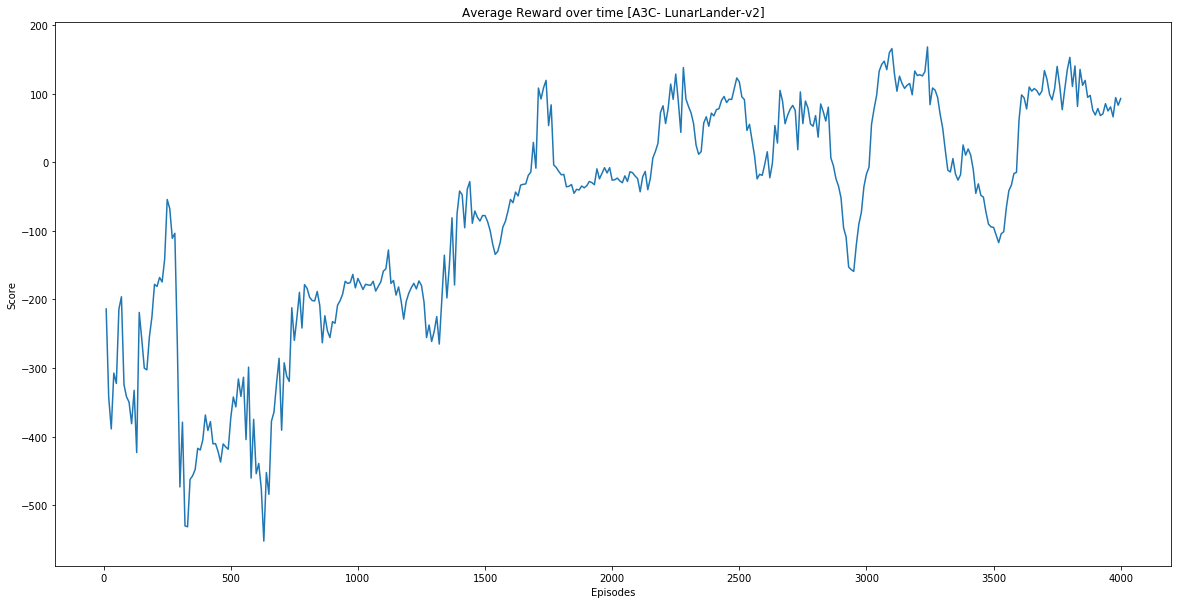

In [309]:
title = "Average Reward over time [A3C- LunarLander-v2]"
x_label = "Episodes"
y_label = "Score"
plot_fig([int(i) for i in log_dict3.keys()], [float(v) for v in log_dict3.values()], title, x_label, y_label)

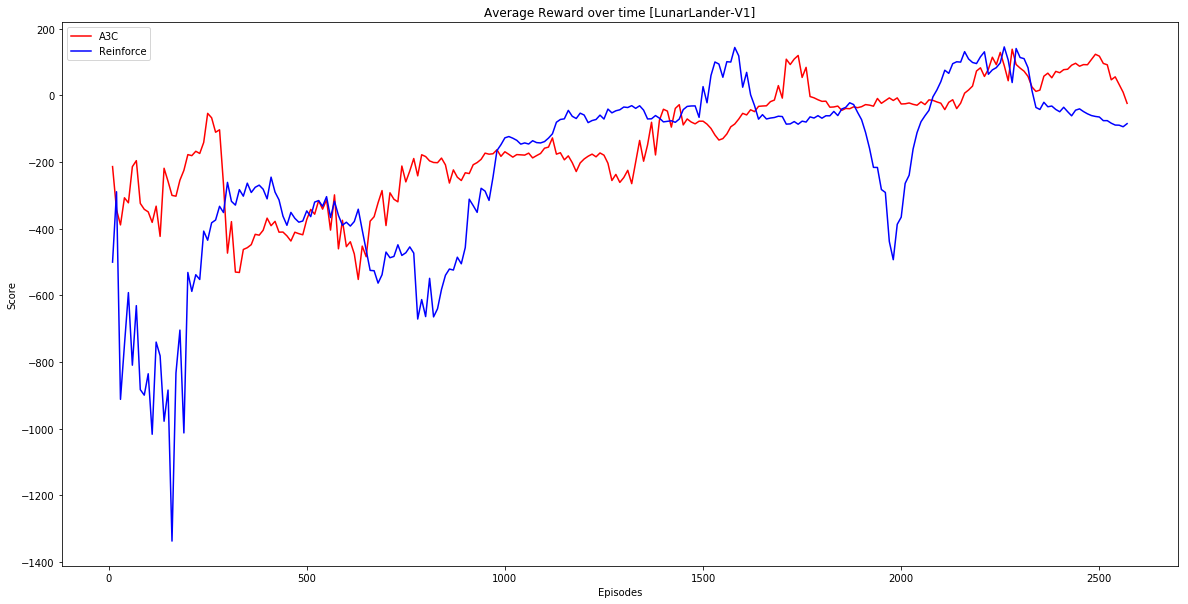

In [321]:
## the title should be LunarLander-V2 actually...please ignore V1. It was a typo.
title = "Average Reward over time [LunarLander-V1]"
x_label = "Episodes"
y_label = "Score"
log_dict3_edit1 = [v for (k,v) in log_dict3.items() if k < 2580]
plot_figs([int(i) for i in log_dict4.keys()], log_dict3_edit1, 
          [float(v) for v in log_dict4.values()], title, x_label, y_label, "A3C", "Reinforce")

In [323]:
np.save('Re_Cartpole.npy', log_dict1)
np.save('A3C_Cartpole.npy', log_dict)

np.save('Re_Lunar_big.npy', log_dict4)

np.save('A3C_Lunar.npy', log_dict3)

---------------------------------------------------------------------------------
#####################################################################################

In [368]:
# You can visualize your policy at any time
run_iteration('eval', 20, agent, gen, render=True)

/home/lilly/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


(tensor(150.7821), None)

## Analysis

Plot the performance of each of your agents for the cartpole task and one additional task. When choosing a new environment, make sure is has a discrete action space. For each plot the x axis should show the total number of episodes the model was trained on, and the y axis shows the average total reward per episode.

You can leave the plots as cell outputs below, or you can save them as images and submit them separately.

### Deliverables
- single plot showing both the REINFORCE algorithm's performance, and A3C's performance on the same plot for the cartpole environment (CartPole-v1).
- single plot showing both the REINFORCE algorithm's performance, and A3C's performance on the same plot for a second environment of your choice (suggested -> LunarLander-v2, it's a little tricky but watching the agent fly spaceships is very entertaining!).
- in every case you models have to learn something for full credit.